In [1]:
import models as mm
import customDatasets
import time
import csv
import matplotlib.pyplot as plt
import json
import torch
import math
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import json

In [2]:
# Local data location
set_path = "..."
camera_imgs_dir_path = "..."
microscope_imgs_dir_path = "..."
labels_file_path = "..."
label_type = "om-regression"
model_weights_path = "..."
dummy_camera_model_weights_path = "..."
dummy_microscope_model_weights_path = "..."

# Define model and training configurations
microscope_img_roi = 1920
camera_img_roi = 1000
img_divisions_n = 2

microscope_img_channels = 3
microscope_height_resize = 224
microscope_width_resize = 224

camera_img_channels = 3
camera_height_resize = 224
camera_width_resize = 224

rotations = [0]

# Loaders batch size
batch_size = 16

# Models Params
model_output_dims = {
    "om-regression": 4,
    "mineral-regression": 3
}
model_type = "tiny"
pre_trained = False
train_only_last_layer = False

# Build loss function
loss_fn = torch.nn.MSELoss()


# Get sets indeices
with open(set_path, "r") as json_file:
    set_dict = json.load(json_file)

test_indices = set_dict["test"]

# Build cropboxes
microscope_sub_img_dim = microscope_img_roi // img_divisions_n
camera_sub_img_dim = camera_img_roi // img_divisions_n

microscope_img_left = 0
microscope_img_upper = 0
microscope_img_right = microscope_sub_img_dim
microscope_img_lower = microscope_sub_img_dim

camera_img_left = 0
camera_img_upper = 0
camera_img_right = camera_sub_img_dim
camera_img_lower = camera_sub_img_dim

# (left, upper, right, lower)
microscope_cropboxes = [(microscope_img_left, microscope_img_upper, microscope_img_right, microscope_img_lower)]
camera_cropboxes = [(camera_img_left, camera_img_upper, camera_img_right, camera_img_lower)]
        
# microscope_cropboxes = customDatasets.createCropBoxes(img_divisions_n, microscope_sub_img_dim)
# camera_cropboxes = customDatasets.createCropBoxes(img_divisions_n, camera_sub_img_dim)


# Transforms
custome_normalization_transform = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

test_dataset = customDatasets.TwoImagesCropboxRotationDataset(
    camera_imgs_dir_path,
    microscope_imgs_dir_path,
    labels_file_path,
    label_type,
    test_indices,
    camera_cropboxes,
    microscope_cropboxes,
    camera_img_channels,
    microscope_img_channels,
    camera_height_resize,
    camera_width_resize,
    microscope_height_resize,
    microscope_width_resize,
    rotations_values=rotations,
    camera_transform=custome_normalization_transform,
    micro_transform=custome_normalization_transform
)

test_dataset_n = test_dataset.__len__()

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

# Build model
model = mm.ConvNext2BTrainer.instantiate_model(_, model_type, label_type, dummy_microscope_model_weights_path, dummy_camera_model_weights_path, train_only_last_layer)

model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))
model.eval()

batch_counter = 0
total_iterations = math.ceil(test_dataset_n / batch_size)

test_labels = []
test_raw_preds = []

for camera_inputs, micro_inputs, labels in test_loader:
    batch_counter += 1
    print("Batch: {}/{}".format(batch_counter, total_iterations))

    # Make predictions for this batch
    raw_preds = model(micro_inputs, camera_inputs)

    # Save predictions and labels
    test_labels.append(labels.numpy())
    test_raw_preds.append(raw_preds.detach().numpy())

predictions = np.concatenate(test_raw_preds, axis=0)
labels = np.concatenate(test_labels, axis=0)

0 samples processed
100 samples processed
Batch: 1/8
Batch: 2/8
Batch: 3/8
Batch: 4/8
Batch: 5/8
Batch: 6/8
Batch: 7/8
Batch: 8/8


In [3]:
mse = np.mean((labels - predictions) ** 2, axis=0)
print("Per feature MSE:", mse)

overall_mse = np.mean(mse)
print("Overall MSE:", overall_mse)

Per feature MSE: [0.00631557 0.00346747 0.00344398 0.00019412]
Overall MSE: 0.0033552868


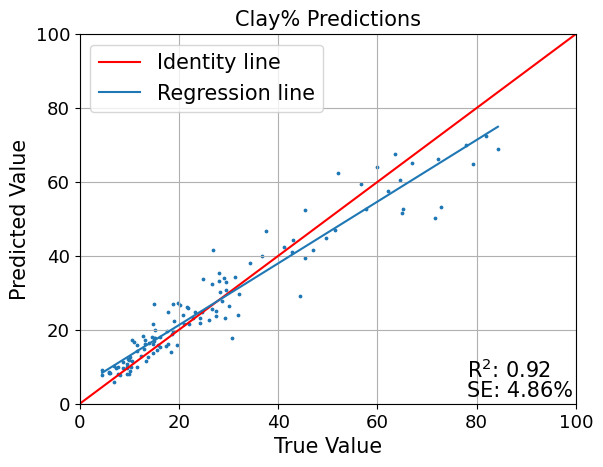

In [33]:
class_n = 2
error_margin = (mse[class_n]**0.5)*100

plot_limit = 100

x = (labels[:,class_n]*100)
y = predictions[:,class_n]*100

# Fit linear regression model
regression_model = LinearRegression()
regression_model.fit(x.reshape(-1, 1), y)
regression_predictions = regression_model.predict(x.reshape(-1, 1))
r2 = r2_score(y, regression_predictions)

regression_slope = regression_model.coef_[0]
regression_intercept = regression_model.intercept_

regression_line_x = [x.min(), x.max()]
regression_line_y = [regression_model.predict(x.min().reshape(-1,1))[0], regression_model.predict(x.max().reshape(-1,1))[0]]

# Standard Error
regression_predictions = regression_model.predict(x.reshape(-1, 1))
standard_error_estimate = round(float(np.sqrt(mean_squared_error(y, regression_predictions))),2)

# Plot identity
plt.plot([0,plot_limit], [0,plot_limit], color='red', label="Identity line")

# Plot regression line
plt.plot(regression_line_x, regression_line_y, label=f"Regression line")
# plt.plot([0,0.3], [0,0.3])
# plt.fill_between([0, plot_limit], [0 - error_margin, plot_limit - error_margin], [0 + error_margin, plot_limit + error_margin],
#                  color='gray', alpha=0.2, label='Error Margin')

plt.scatter(x, y, s=3)

# text_x=15.5
# text_y1= 0.5
# text_y2= 1.5

text_x=78
text_y1= 2
text_y2= 7

font_size=15

plt.text(text_x, text_y1, f'SE: {standard_error_estimate}%', fontsize=font_size, color='black')
plt.text(text_x, text_y2, f'R$^2$: {round(r2,2)}', fontsize=font_size, color='black')

plt.tick_params(axis='both', which='major', labelsize=13)
plt.tick_params(axis='both', which='minor', labelsize=13)

plt.xlim(0,plot_limit)
plt.ylim(0,plot_limit)

plt.xlabel("True Value", fontsize=font_size)
plt.ylabel("Predicted Value", fontsize=font_size)
plt.title("Clay% Predictions", fontsize=font_size)

plt.grid(True)

plt.legend(fontsize=font_size)

dpi=500
plt.savefig("./Figures/clayPredictions.png", dpi=dpi)